In [2]:
import torch
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
import tensorflow as tf
from torch.optim import AdamW
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import classification_report, f1_score, accuracy_score
from transformers import BertForSequenceClassification, AutoTokenizer

# pd.set_option('Display.max_colwidth',None)

In [33]:
model = BertForSequenceClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.2", num_labels=14, use_safetensors=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
tok = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.2", do_lower_case=True)
tok.save_pretrained("./tokenizer_cache")

('./tokenizer_cache/tokenizer_config.json',
 './tokenizer_cache/special_tokens_map.json',
 './tokenizer_cache/vocab.txt',
 './tokenizer_cache/added_tokens.json',
 './tokenizer_cache/tokenizer.json')

In [35]:
df_train_small= pd.read_csv('train-data-small.csv') #PubMed-Multilabel-Classifiction/data/
df_train_small.drop(columns=['Unnamed: 0'], inplace=True)
df_test_small= pd.read_csv('test-data-small.csv') #PubMed-Multilabel-Classifiction/data/
df_test_small.drop(columns=['Unnamed: 0'], inplace=True)
df_dev_small= pd.read_csv('dev-data-small.csv') #PubMed-Multilabel-Classifiction/data/
df_dev_small.drop(columns=['Unnamed: 0'], inplace=True)
df_train_small.head(3)

,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,D,E,F,G,H,I,J,L,M,N,Z
0,Upregulation of plakophilin-2 and its acquisit...,In contrast to the desmosome-containing epithe...,"['Adherens Junctions', 'Animals', 'Cell Adhesi...",19551809,"[['A11.284.149.165.420.020'], ['B01.050'], ['G...","['Anatomy [A]', 'Organisms [B]', 'Phenomena an...",1,1,1,1,0,0,1,0,0,0,0,0,0,0
1,Parasite infracommunities of Leporinus frideri...,The degradation and homogenization of natural ...,"['Animals', 'Biodiversity', 'Brazil', 'Characi...",28489196,"[['B01.050'], ['G16.500.275.157.049', 'N06.230...","['Organisms [B]', 'Phenomena and Processes [G]...",0,1,0,0,1,0,1,0,1,0,0,0,1,1
2,Plasma catecholamine concentrations in hyperth...,Using a modification of the fluorometric metho...,"['Age Factors', 'Epinephrine', 'Humans', 'Hype...",958003,"[['N05.715.350.075', 'N06.850.490.250'], ['D02...","['Health Care [N]', 'Chemicals and Drugs [D]',...",0,1,1,1,0,0,0,0,0,0,0,0,1,0


In [36]:
print("Total number of Articles extracted [Test] =",len(df_test_small))
print("Total number of Articles extracted [Train] =",len(df_train_small))
print("Total number of Articles extracted [Dev] =",len(df_dev_small))

Total number of Articles extracted [Test] = 250
Total number of Articles extracted [Train] = 800
Total number of Articles extracted [Dev] = 200


In [37]:
cols = df_train_small.columns
cols = list(df_train_small.columns)
mesh_Heading_categories = cols[6:]
num_labels = len(mesh_Heading_categories)
print('Mesh Labels Root Class: "\n"',mesh_Heading_categories)
print("\n")
print('Number of Labels: ' ,num_labels)


Mesh Labels Root Class: "
" ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'Z']


Number of Labels:  14


In [39]:
df_train_small['one_hot_labels'] = list(df_train_small[mesh_Heading_categories].values)
df_dev_small['one_hot_labels'] = list(df_dev_small[mesh_Heading_categories].values)
df_train_small.head(3)

,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,D,...,F,G,H,I,J,L,M,N,Z,one_hot_labels
0,Upregulation of plakophilin-2 and its acquisit...,In contrast to the desmosome-containing epithe...,"['Adherens Junctions', 'Animals', 'Cell Adhesi...",19551809,"[['A11.284.149.165.420.020'], ['B01.050'], ['G...","['Anatomy [A]', 'Organisms [B]', 'Phenomena an...",1,1,1,1,...,0,1,0,0,0,0,0,0,0,"[1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
1,Parasite infracommunities of Leporinus frideri...,The degradation and homogenization of natural ...,"['Animals', 'Biodiversity', 'Brazil', 'Characi...",28489196,"[['B01.050'], ['G16.500.275.157.049', 'N06.230...","['Organisms [B]', 'Phenomena and Processes [G]...",0,1,0,0,...,0,1,0,1,0,0,0,1,1,"[0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1]"
2,Plasma catecholamine concentrations in hyperth...,Using a modification of the fluorometric metho...,"['Age Factors', 'Epinephrine', 'Humans', 'Hype...",958003,"[['N05.715.350.075', 'N06.850.490.250'], ['D02...","['Health Care [N]', 'Chemicals and Drugs [D]',...",0,1,1,1,...,0,0,0,0,0,0,0,1,0,"[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"


In [40]:
labels_train = list(df_train_small.one_hot_labels.values)
Article_train = list(df_train_small.abstractText.values)

labels_dev = list(df_dev_small.one_hot_labels.values)
Article_dev = list(df_dev_small.abstractText.values)

<a id="4"></a>
## <p style="background-color:#1a0a36;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> Tokenizations</p>
#### [Top ↑](#top)

In [ ]:
tokenizer = tok

In [47]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [48]:
optimizer = AdamW(optimizer_grouped_parameters,lr=6e-6)
# optimizer = AdamW(model.parameters(),lr=4e-5)  # Default optimization #XL-NET

In [49]:
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'

In [54]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn import BCEWithLogitsLoss
from sklearn.metrics import f1_score, hamming_loss, accuracy_score
from tqdm import trange
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

max_length = 128
batch_size = 16

train_encodings = tokenizer(
    Article_train, padding=True, truncation=True, max_length=max_length, return_tensors='pt'
)
dev_encodings = tokenizer(
    Article_dev, padding=True, truncation=True, max_length=max_length, return_tensors='pt'
)

train_labels_tensor = torch.tensor(labels_train, dtype=torch.float)
dev_labels_tensor = torch.tensor(labels_dev, dtype=torch.float)

train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels_tensor)
dev_dataset = TensorDataset(dev_encodings['input_ids'], dev_encodings['attention_mask'], dev_labels_tensor)

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
dev_dataloader = DataLoader(dev_dataset, sampler=SequentialSampler(dev_dataset), batch_size=batch_size)

epochs = 25
num_labels = train_labels_tensor.shape[1]
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

metrics_per_epoch = []

for epoch in trange(epochs, desc="Epoch"):
    # ----- TRAIN -----
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]

        optimizer.zero_grad()
        logits = model(b_input_ids, attention_mask=b_input_mask)[0]

        loss_func = BCEWithLogitsLoss()
        loss = loss_func(logits, b_labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_dataloader)

    # ----- VALIDATION -----
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dev_dataloader:
            b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]
            logits = model(b_input_ids, attention_mask=b_input_mask)[0]
            preds = torch.sigmoid(logits)

            all_preds.append(preds.cpu())
            all_labels.append(b_labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Apply threshold for binary predictions
    threshold = 0.5
    pred_bools = all_preds > threshold
    true_bools = all_labels == 1

    # Metrics
    micro_f1 = f1_score(true_bools, pred_bools, average='micro')
    macro_f1 = f1_score(true_bools, pred_bools, average='macro')
    weighted_f1 = f1_score(true_bools, pred_bools, average='weighted')

    exact_match_ratio = np.mean(np.all(pred_bools == true_bools, axis=1))
    hamming = hamming_loss(true_bools, pred_bools)

    # Store metrics
    metrics_per_epoch.append({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "micro_f1": micro_f1,
        "macro_f1": macro_f1,
        "weighted_f1": weighted_f1,
        "exact_match_ratio": exact_match_ratio,
        "hamming_loss": hamming,
        "output_str": (
            f"Micro F1: {micro_f1:.6f}; "
            f"Macro F1: {macro_f1:.6f}; "
            f"Weighted F1: {weighted_f1:.6f}; "
            f"Exact Match: {exact_match_ratio:.6f}; "
            f"Hamming Loss: {hamming:.6f}"
        )
    })

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Micro F1: {micro_f1:.4f} | Exact Match: {exact_match_ratio:.4f}")

# metrics_per_epoch now contains 25 dictionaries with all metrics


Epoch:   4%|▍         | 1/25 [00:08<03:31,  8.80s/it]

Epoch 1 | Train Loss: 0.3310 | Micro F1: 0.8178 | Exact Match: 0.0900


Epoch:   8%|▊         | 2/25 [00:17<03:23,  8.85s/it]

Epoch 2 | Train Loss: 0.3019 | Micro F1: 0.8245 | Exact Match: 0.0950


Epoch:  12%|█▏        | 3/25 [00:26<03:15,  8.89s/it]

Epoch 3 | Train Loss: 0.2786 | Micro F1: 0.8245 | Exact Match: 0.1000


Epoch:  16%|█▌        | 4/25 [00:35<03:07,  8.94s/it]

Epoch 4 | Train Loss: 0.2541 | Micro F1: 0.8227 | Exact Match: 0.0900


Epoch:  20%|██        | 5/25 [00:44<02:59,  8.99s/it]

Epoch 5 | Train Loss: 0.2319 | Micro F1: 0.8261 | Exact Match: 0.1000


Epoch:  24%|██▍       | 6/25 [00:53<02:51,  9.03s/it]

Epoch 6 | Train Loss: 0.2097 | Micro F1: 0.8271 | Exact Match: 0.1050


Epoch:  28%|██▊       | 7/25 [01:03<02:43,  9.08s/it]

Epoch 7 | Train Loss: 0.1916 | Micro F1: 0.8225 | Exact Match: 0.0950


Epoch:  32%|███▏      | 8/25 [01:12<02:35,  9.13s/it]

Epoch 8 | Train Loss: 0.1729 | Micro F1: 0.8253 | Exact Match: 0.1000


Epoch:  36%|███▌      | 9/25 [01:21<02:27,  9.19s/it]

Epoch 9 | Train Loss: 0.1625 | Micro F1: 0.8296 | Exact Match: 0.0850


Epoch:  40%|████      | 10/25 [01:30<02:18,  9.25s/it]

Epoch 10 | Train Loss: 0.1458 | Micro F1: 0.8216 | Exact Match: 0.1050


Epoch:  44%|████▍     | 11/25 [01:40<02:10,  9.30s/it]

Epoch 11 | Train Loss: 0.1320 | Micro F1: 0.8305 | Exact Match: 0.1200


Epoch:  48%|████▊     | 12/25 [01:49<02:01,  9.34s/it]

Epoch 12 | Train Loss: 0.1183 | Micro F1: 0.8240 | Exact Match: 0.1150


Epoch:  52%|█████▏    | 13/25 [01:59<01:52,  9.37s/it]

Epoch 13 | Train Loss: 0.1081 | Micro F1: 0.8307 | Exact Match: 0.1150


Epoch:  56%|█████▌    | 14/25 [02:08<01:43,  9.38s/it]

Epoch 14 | Train Loss: 0.0992 | Micro F1: 0.8240 | Exact Match: 0.1100


Epoch:  60%|██████    | 15/25 [02:18<01:33,  9.39s/it]

Epoch 15 | Train Loss: 0.0907 | Micro F1: 0.8277 | Exact Match: 0.1150


Epoch:  64%|██████▍   | 16/25 [02:27<01:24,  9.38s/it]

Epoch 16 | Train Loss: 0.0828 | Micro F1: 0.8236 | Exact Match: 0.0900


Epoch:  68%|██████▊   | 17/25 [02:36<01:15,  9.38s/it]

Epoch 17 | Train Loss: 0.0766 | Micro F1: 0.8208 | Exact Match: 0.1000


Epoch:  72%|███████▏  | 18/25 [02:46<01:05,  9.37s/it]

Epoch 18 | Train Loss: 0.0701 | Micro F1: 0.8205 | Exact Match: 0.0950


Epoch:  76%|███████▌  | 19/25 [02:55<00:56,  9.36s/it]

Epoch 19 | Train Loss: 0.0647 | Micro F1: 0.8260 | Exact Match: 0.0900


Epoch:  80%|████████  | 20/25 [03:04<00:46,  9.36s/it]

Epoch 20 | Train Loss: 0.0599 | Micro F1: 0.8219 | Exact Match: 0.1000


Epoch:  84%|████████▍ | 21/25 [03:14<00:37,  9.37s/it]

Epoch 21 | Train Loss: 0.0555 | Micro F1: 0.8242 | Exact Match: 0.1050


Epoch:  88%|████████▊ | 22/25 [03:23<00:28,  9.37s/it]

Epoch 22 | Train Loss: 0.0518 | Micro F1: 0.8227 | Exact Match: 0.0850


Epoch:  92%|█████████▏| 23/25 [03:32<00:18,  9.37s/it]

Epoch 23 | Train Loss: 0.0483 | Micro F1: 0.8257 | Exact Match: 0.0950


Epoch:  96%|█████████▌| 24/25 [03:42<00:09,  9.38s/it]

Epoch 24 | Train Loss: 0.0446 | Micro F1: 0.8251 | Exact Match: 0.1050


Epoch: 100%|██████████| 25/25 [03:51<00:00,  9.27s/it]

Epoch 25 | Train Loss: 0.0423 | Micro F1: 0.8288 | Exact Match: 0.1000


In [74]:

import json

# Save metrics to JSON
with open("bert_metrics_25epochs.json", "w") as f:
    json.dump(metrics_per_epoch, f, indent=4)

In [69]:
num_epochs = np.arange(1,len(train_loss_list)+1)
# df_train_results=pd.DataFrame({'Epochs':num_epochs,'F1 Validation Accuracy':val_f1_list,\
#                                'Flat Validation Accuracy':val_acc_list,'Train loss':train_loss_list})

<a id="8"></a>
## <p style="background-color:#1a0a36;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> Visualizing The results</p>

#### [Top ↑](#top)

In [70]:

train_loss_list = [epoch_metrics["train_loss"] for epoch_metrics in metrics_per_epoch]


In [71]:
train_loss_list

[0.331017392873764,
 0.30194034934043884,
 0.2785560944676399,
 0.25405761480331424,
 0.23192903846502305,
 0.20969397962093353,
 0.1916386553645134,
 0.1729474127292633,
 0.16247487634420396,
 0.14584134459495546,
 0.13197898611426354,
 0.1182912415266037,
 0.10810628235340118,
 0.0991976560652256,
 0.09068560771644116,
 0.08283359572291374,
 0.07657397463917733,
 0.07012158863246441,
 0.06469025298953056,
 0.0599439226090908,
 0.05550281338393688,
 0.05178620882332325,
 0.04826451629400253,
 0.04457071281969547,
 0.042308114990592005]

Text(0.5, 1.0, 'Training Loss vs Number of Epochs for Bert-Base')

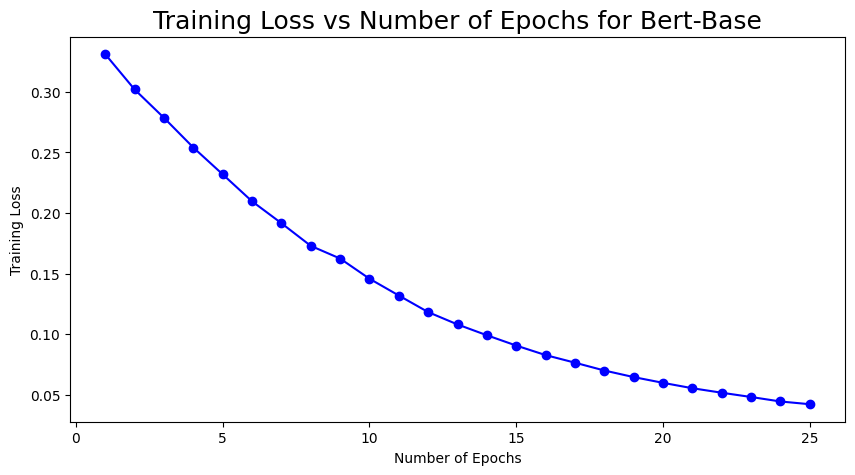

In [73]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_list) ,'bo-',label="Train Loss")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Training Loss")
ax.set_title("Training Loss vs Number of Epochs for Bert-Base",fontsize=18)

In [62]:
# fig, ax = plt.subplots(figsize=(10, 7));
# ax.plot(num_epochs, np.array(val_f1_accuracy_list),'ro-' ,label="F1 Validation Accuracy")
# ax.set_xlabel("Number of Epochs")
# ax.set_ylabel("F1 Validation Accuracy")
# ax.set_title("F1 Validation Accuracy vs Number of Epochs for Bert-Base",fontsize=18)
# ax.set_ylim(0, 100)

In [61]:
# fig, ax = plt.subplots(figsize=(10, 5));
# ax.plot(num_epochs, np.array(val_flat_accuracy_list),'go-', label="Flat Validation Accuracy")
# ax.set_xlabel("Number of Epochs")
# ax.set_ylabel("Flat Validation Accuracy")
# ax.set_title("Flat Validation Accuracy vs Number of Epochs for for Bert-Base",fontsize=18)
# ax.set_ylim(0, 100)

In [55]:
df_test_small['one_hot_labels'] = list(df_test_small[mesh_Heading_categories].values)
df_test_small.head(3)

,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,D,...,F,G,H,I,J,L,M,N,Z,one_hot_labels
0,Computational analysis of glycoside hydrolase ...,Glycoside hydrolase family 1 consists of beta-...,"['Amino Acid Sequence', 'Carbohydrate Conforma...",18615662,"[['G02.111.570.060', 'L01.453.245.667.060'], [...","['Phenomena and Processes [G]', 'Information S...",0,0,0,1,...,0,1,0,0,0,1,0,0,0,"[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]"
1,Induction of smoking urge through imaginal and...,This experiment assessed reactivity to imagina...,"['Adult', 'Analysis of Variance', 'Cues', 'Fem...",9103714,"[['M01.060.116'], ['E05.318.740.150', 'N05.715...","['Named Groups [M]', 'Analytical, Diagnostic a...",0,1,1,0,...,1,0,0,0,0,0,1,1,0,"[0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0]"
2,"Owners' view of their pets' emotions, intellec...",Companion animals have established special rel...,"['Animals', 'Behavior, Animal', 'Cats', 'Cogni...",28267573,"[['B01.050'], ['F01.145.113'], ['B01.050.150.9...","['Organisms [B]', 'Psychiatry and Psychology [...",0,1,0,0,...,1,0,0,0,0,0,0,1,0,"[0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0]"


In [56]:
test_labels = list(df_test_small.one_hot_labels.values)
Articles_test = list(df_test_small.abstractText.values)
test_mesh_categories = list(df_test_small.columns[6:20])

In [57]:
# Encoding input data
test_encodings = tokenizer.batch_encode_plus(Articles_test,max_length=max_length,padding=True,truncation=True)
test_input_ids = test_encodings['input_ids']
test_attention_masks = test_encodings['attention_mask']

In [58]:
# Make tensors out of data
test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_attention_masks)
# Create test dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels,)# test_token_types)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
# Save test dataloader
torch.save(test_dataloader,'test_data_loader')

<a id="9"></a>
## <p style="background-color:#1a0a36;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> Evaluating the model</p>
#### [Top ↑](#top)

In [59]:
%%time

# Test

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

#track variables
logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, = batch
    with torch.no_grad():
        # Forward pass
        outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        b_logit_pred = outs[0]
        pred_label = torch.sigmoid(b_logit_pred)

        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]
# Converting flattened binary values to boolean values
true_bools = [tl==1 for tl in true_labels]

CPU times: user 726 ms, sys: 0 ns, total: 726 ms
Wall time: 726 ms


<a id="10"></a>
## <p style="background-color:#1a0a36;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> Classification Report</p>
#### [Top ↑](#top)


In [60]:
pred_bools = [pl>0.50 for pl in pred_labels] #boolean output after thresholding
# Print and save classification report
Test_F1_Accuracy=f1_score(true_bools, pred_bools,average='micro')
Test_Flat_Accuracy= accuracy_score(true_bools, pred_bools)
print('Test F1 Accuracy: ',Test_F1_Accuracy )
print('Test Flat Accuracy: ',Test_Flat_Accuracy,'\n')

df_test=pd.DataFrame({'Test F1 Accuracy':Test_F1_Accuracy, 'Test Flat Accuracy':Test_Flat_Accuracy},index=[0])

print(classification_report(true_bools,pred_bools,target_names=test_mesh_categories))
clf_report = classification_report(true_bools,pred_bools,target_names=test_mesh_categories,output_dict=True)
df_report=pd.DataFrame(clf_report).transpose()



Test F1 Accuracy:  0.8337366055997235
Test Flat Accuracy:  0.116 

              precision    recall  f1-score   support

           A       0.70      0.73      0.71       110
           B       0.95      0.99      0.97       235
           C       0.80      0.82      0.81       133
           D       0.92      0.92      0.92       165
           E       0.78      0.94      0.85       190
           F       0.94      0.73      0.82        44
           G       0.76      0.92      0.83       169
           H       0.25      0.17      0.20        12
           I       0.69      0.62      0.65        29
           J       0.74      0.52      0.61        27
           L       0.85      0.46      0.60        50
           M       0.87      0.85      0.86       119
           N       0.77      0.79      0.78       111
           Z       0.81      0.62      0.70        34

   micro avg       0.82      0.84      0.83      1428
   macro avg       0.77      0.72      0.74      1428
weighted avg 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
df_report.to_csv('Classification_Report.csv',index=False)